# Import Libraries

In [15]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np

In [16]:
# load the model
new_model = keras.models.load_model('cnn_lstm_original_model.keras')

# Data preprocessing & Analysis

In [17]:
# For data preprocessing and analysis part

data = pd.read_csv('../../Datasets/NVDA.csv')


data.dropna(inplace=True)
data.head()

data.reset_index(drop=True, inplace=True)

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
data.head()

df2 = data.drop('Date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

          Open      High      Low   Close    Volume
0      18.5100   18.6200   18.110   18.49  20005100
1      18.5100   18.9600   18.420   18.76  18216200
2      18.7500   18.9200   18.570   18.88  16229200
3      18.7800   18.8600   18.370   18.51  13694800
4      18.3600   18.6821   18.250   18.55  11954200
...        ...       ...      ...     ...       ...
2763  530.2400  531.0000  520.200  520.37   4478569
2764  521.4900  525.3000  517.550  519.75   2447088
2765  522.5000  522.5000  510.527  516.00   5286655
2766  517.0000  522.9000  513.690  517.73   4259304
2767  519.6124  528.5500  515.870  525.83   5634929

[2768 rows x 5 columns]
2132
534


In [18]:
new_model.evaluate(test_X, test_Y)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8109 - mae: 0.6602 - mse: 0.8104


[0.6346238255500793, 0.6341349482536316, 0.5992679595947266]

In [19]:
# make predictions
predicted  = new_model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


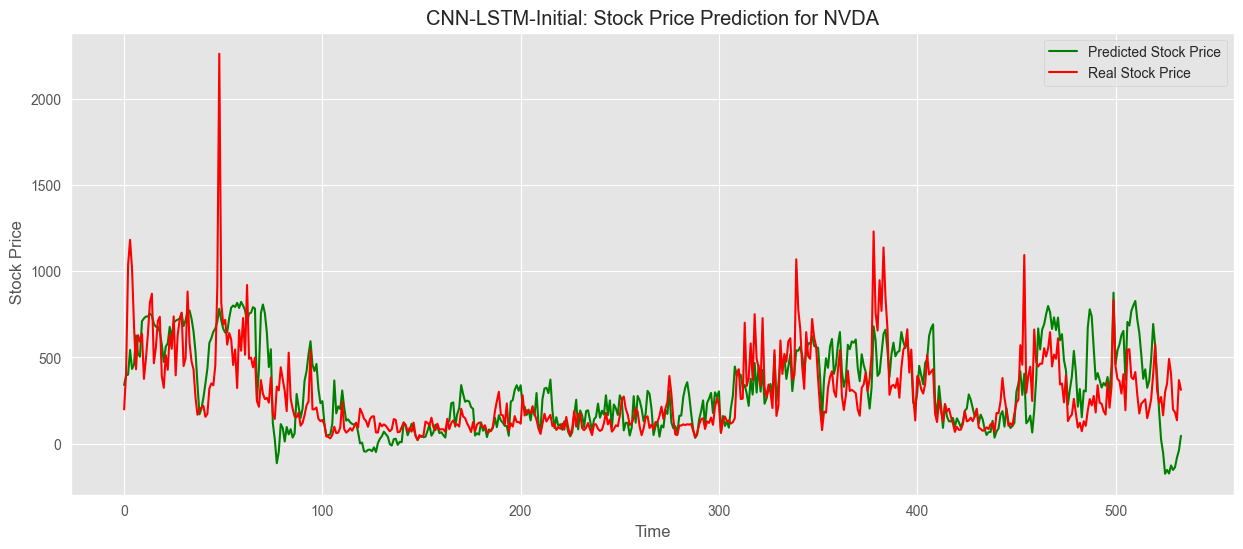

In [20]:
plt.figure(figsize=(15,6))
plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title('CNN-LSTM-Initial: Stock Price Prediction for NVDA')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Performance Evaluation

In [21]:
# Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score


# Calculate performance metrics
mse = mean_squared_error(test_label, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_label, predicted)
mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
r2 = r2_score(test_label, predicted)
# r2 = r2_score(actual_prices, predictions)

# Print performance metrics
print("\nPerformance Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R2 Score: {r2:.3f}")


Performance Metrics:
Mean Squared Error (MSE): 37568.29772073607
Root Mean Squared Error (RMSE): 193.82543104746617
Mean Absolute Error (MAE): 137.0903948359573
Mean Absolute Percentage Error (MAPE): 59.99%
R2 Score: 0.312


In [22]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [23]:
# Save metrics to CSV
save_metrics(test_label, predicted, "CNN-LSTM-Baseline", "NVDA")  


Metrics for CNN-LSTM-Baseline on NVDA:
Mean Squared Error (MSE): 37568.2977
Root Mean Squared Error (RMSE): 193.8254
Mean Absolute Error (MAE): 137.0904
Mean Absolute Percentage Error (MAPE): 59.9914%
R² Score: 0.3124
